# data


In [5]:
 import pandas as pd

file_path = r'C:\Users\zhuc2\Desktop\fall2024\stats507\heart (3).csv'
heart_data = pd.read_csv(file_path)

print(heart_data.head())


   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


clean the dataset

In [6]:
#drop rows with missing values
heart_data.dropna(inplace=True)
#sex:feamle=1, male=2
#restingecg: normal=1, st=2
#exerciseangina: n=1 y=2
#st_slop:up=1, flat=2

heart_data['Sex'] = heart_data['Sex'].map({'F': 1, 'M': 2})
heart_data['RestingECG'] = heart_data['RestingECG'].map({'Normal': 1, 'ST': 2})
heart_data['ExerciseAngina'] = heart_data['ExerciseAngina'].map({'N': 1, 'Y': 2})
heart_data['ST_Slope'] = heart_data['ST_Slope'].map({'Up': 1, 'Flat': 2})
# Replace ChestPainType with binary columns
heart_data = pd.get_dummies(heart_data, columns=['ChestPainType'], prefix='ChestPainType')


#drop all outliers
def drop_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# List of numerical columns to check for outliers
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
heart_data = drop_outliers(heart_data, numerical_columns)

print(heart_data.head())

   Age  Sex  RestingBP  Cholesterol  FastingBS  RestingECG  MaxHR  \
0   40    2        140          289          0         1.0    172   
1   49    1        160          180          0         1.0    156   
2   37    2        130          283          0         2.0     98   
3   48    1        138          214          0         1.0    108   
4   54    2        150          195          0         1.0    122   

   ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  ChestPainType_ASY  \
0               1      0.0       1.0             0                  0   
1               1      1.0       2.0             1                  0   
2               1      0.0       1.0             0                  0   
3               2      1.5       2.0             1                  1   
4               1      0.0       1.0             0                  0   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  
0                  1                  0                 0  
1                  0      

Use correlation coefficient, chi-square test, ANOVA F-test, variance threshold as the filter methods to do the feature selection in variables

In [7]:
from sklearn.feature_selection import chi2, f_classif, VarianceThreshold
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

heart_data.dropna(inplace=True)
# Define binary and non-binary columns
binary_columns = ['Sex','FastingBS','RestingECG','ExerciseAngina', 'ST_Slope','ChestPainType_ATA','ChestPainType_ASY','ChestPainType_NAP','ChestPainType_TA']
non_binary_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target_column = 'HeartDisease'

# Define features (X) and target (y)
X = heart_data.drop('HeartDisease', axis=1)
y = heart_data['HeartDisease']


#1. The Chi-square test is suitable for categorical (binary) variables to check their association with the target.
chi2_scores, p_values = chi2(X[binary_columns], y)

# Create a DataFrame to view the scores and p-values
binary_feature_selection = pd.DataFrame({
    'Feature': binary_columns,
    'Chi2 Score': chi2_scores,
    'P-Value': p_values
})

print("Binary Feature Selection Results:")
print(binary_feature_selection)

#2. Correlation Coefficient with Pearson for non-binary variables
pearson_results = []
for col in non_binary_columns:
    corr, p_val = pearsonr(X[col], y)
    pearson_results.append({'Feature': col, 'Pearson Correlation': corr, 'P-Value': p_val})

pearson_df = pd.DataFrame(pearson_results)
print("Non-Binary Feature Selection using Pearson Correlation:")
print(pearson_df)


f_scores, p_values = f_classif(X[non_binary_columns], y)


anova_feature_selection = pd.DataFrame({
    'Feature': non_binary_columns,
    'F-Score': f_scores,
    'P-Value': p_values
})

print("Non-Binary Feature Selection Results using ANOVA F-test:")
print(anova_feature_selection)

variance_selector = VarianceThreshold(threshold=0.1)
variance_selector.fit(X[non_binary_columns])

selected_variance_features = X[non_binary_columns].columns[variance_selector.get_support()]

print("Selected Non-Binary Features by Variance Threshold:")
print(selected_variance_features.tolist())



Binary Feature Selection Results:
             Feature  Chi2 Score       P-Value
0                Sex    4.671255  3.067151e-02
1          FastingBS   19.086751  1.249090e-05
2         RestingECG    1.046841  3.062357e-01
3     ExerciseAngina   30.540549  3.269607e-08
4           ST_Slope   47.484355  5.544468e-12
5  ChestPainType_ATA   67.711122  1.892927e-16
6  ChestPainType_ASY   73.106902  1.228143e-17
7  ChestPainType_NAP    9.810182  1.735484e-03
8   ChestPainType_TA    0.018018  8.932197e-01
Non-Binary Feature Selection using Pearson Correlation:
       Feature  Pearson Correlation       P-Value
0          Age             0.312284  3.904141e-13
1    RestingBP             0.181774  3.270740e-05
2  Cholesterol             0.129325  3.251016e-03
3        MaxHR            -0.411757  1.555816e-22
4      Oldpeak             0.540995  1.455425e-40
Non-Binary Feature Selection Results using ANOVA F-test:
       Feature     F-Score       P-Value
0          Age   55.542541  3.904141e-13
1

From this result, the most importance features for binary variables are ChestPainType_ASY, ChestPainType_ATA, ST-Sope, ExerciseAngina, FastingBS, ChestPainType_NAP. We reject Sex, RestingECG, ChestPainType_TA since their p-value>0.01.
For non_binary variables, the importance of features (high to low) is Oldpeak, MaxHR, Age, RestingBP, Cholesterol. Their p-value are bigger than 0.01, non of them reject.


I will use Recursive Feature Elimination (RFE) as the wrapper methods

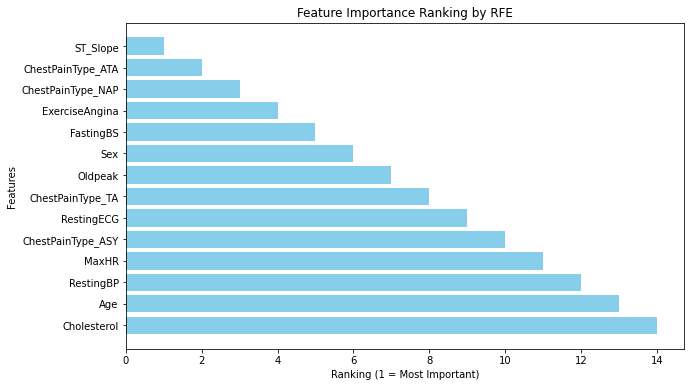

Feature Importance Ranking (High to Low):
              Feature  Ranking  Support
9            ST_Slope        1     True
11  ChestPainType_ATA        2    False
12  ChestPainType_NAP        3    False
7      ExerciseAngina        4    False
4           FastingBS        5    False
1                 Sex        6    False
8             Oldpeak        7    False
13   ChestPainType_TA        8    False
5          RestingECG        9    False
10  ChestPainType_ASY       10    False
6               MaxHR       11    False
2           RestingBP       12    False
0                 Age       13    False
3         Cholesterol       14    False


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import pandas as pd

# Define the logistic regression model and RFE
model = LogisticRegression(max_iter=200, solver='liblinear')  # 'liblinear' solver is suitable for smaller datasets
rfe = RFE(estimator=model, n_features_to_select=1)  # Selecting all features to rank them by importance
rfe.fit(X, y)


ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_, 'Support': rfe.support_})
ranking = ranking.sort_values(by='Ranking', ascending=True)


plt.figure(figsize=(10, 6))
plt.barh(ranking['Feature'], ranking['Ranking'], color='skyblue')
plt.xlabel("Ranking (1 = Most Important)")
plt.ylabel("Features")
plt.title("Feature Importance Ranking by RFE")
plt.gca().invert_yaxis()  
plt.show()
print("Feature Importance Ranking (High to Low):")
print(ranking)

Filter Methods (Correlation Coefficient, Chi-Square, ANOVA F-test, and Variance Threshold):

These methods assess each feature individually, measuring its direct association with the target variable without considering interactions between features.
For example, ANOVA F-test and Chi-Square test evaluate the variance and independence of features with respect to the target. Features with low p-values are deemed important.
This can lead to selecting features that have high individual significance but might be redundant or less impactful in a multivariate setting.
Wrapper Method (RFE):

RFE evaluates feature importance based on the model’s performance with different subsets of features, accounting for interactions between features.

By recursively removing the least important features and re-evaluating the model, RFE selects features that contribute more to the overall model performance rather than just individual significance.
This approach tends to select fewer features overall, focusing on the ones that truly improve model performance in combination with others.

Final Selected Features (Combined Approach)
To balance between individual feature significance and overall model performance, the following combined features are suggested:

ST_Slope

ChestPainType_ATA

ChestPainType_NAP

ExerciseAngina

FastingBS

Oldpeak

ChestPainType_ASY

MaxHR

These features were consistently ranked high in either filter methods or RFE and are likely to contribute meaningfully to the model when used together. This combined approach leverages both individual feature significance and multivariate importance for robust feature selection.

build a logistic regression classification model using PyTorch with the selected features

Epoch [100/1000], Loss: 0.3207, Validation Accuracy: 0.9135
Epoch [200/1000], Loss: 0.3113, Validation Accuracy: 0.9038
Epoch [300/1000], Loss: 0.3090, Validation Accuracy: 0.9038
Epoch [400/1000], Loss: 0.3085, Validation Accuracy: 0.9038
Epoch [500/1000], Loss: 0.3084, Validation Accuracy: 0.9038
Epoch [600/1000], Loss: 0.3084, Validation Accuracy: 0.9038
Epoch [700/1000], Loss: 0.3084, Validation Accuracy: 0.9038
Epoch [800/1000], Loss: 0.3084, Validation Accuracy: 0.9038
Epoch [900/1000], Loss: 0.3084, Validation Accuracy: 0.9038
Epoch [1000/1000], Loss: 0.3084, Validation Accuracy: 0.9038
Final Accuracy on test set: 0.9038


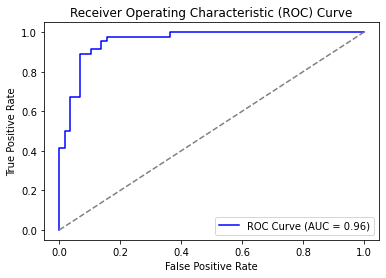

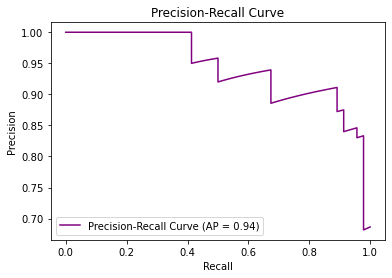

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


selected_features = ["ST_Slope", "ChestPainType_ATA", "ChestPainType_NAP", "ExerciseAngina",
                     "FastingBS", "Oldpeak", "ChestPainType_ASY", "MaxHR"]
X = heart_data[selected_features].values  # Features
y = heart_data["HeartDisease"].values  # Target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)  


epochs = 1000
best_accuracy = 0
early_stop_count = 0
early_stop_threshold = 10

for epoch in range(epochs):
    model.train()
    
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_predictions = val_outputs.round()
            val_accuracy = accuracy_score(y_test, val_predictions.numpy())
            
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')
            
            
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                early_stop_count = 0
            else:
                early_stop_count += 1
                if early_stop_count >= early_stop_threshold:
                    print("Early stopping triggered.")
                    break


model.eval()
with torch.no_grad():
    final_predictions = model(X_test).numpy()
    final_predictions_rounded = (final_predictions >= 0.5).astype(int) 
    accuracy = accuracy_score(y_test, final_predictions_rounded)
    print(f'Final Accuracy on test set: {accuracy:.4f}')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_predictions)
average_precision = average_precision_score(y_test, final_predictions)

plt.figure()
plt.plot(recall, precision, color='purple', label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


The logistic regression model, using the selected features and optimized with normalization, early stopping, and Adam optimization, proved to be highly effective for this binary classification task. The high accuracy, AUC, and AP scores indicate that this model is reliable for predicting heart disease, with strong performance in both sensitivity (recall) and precision.

build a randon forest classification model using PyTorch with the selected features

Epoch [100/1000], Loss: 0.2634
Epoch [200/1000], Loss: 0.2136
Epoch [300/1000], Loss: 0.1810
Epoch [400/1000], Loss: 0.1604
Epoch [500/1000], Loss: 0.1493
Epoch [600/1000], Loss: 0.1425
Epoch [700/1000], Loss: 0.1379
Epoch [800/1000], Loss: 0.1340
Epoch [900/1000], Loss: 0.1310
Epoch [1000/1000], Loss: 0.1290
Final Accuracy on test set: 0.8750


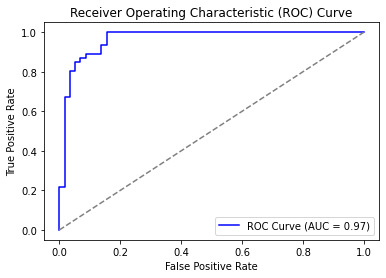

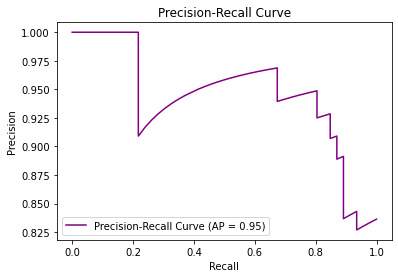

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np


selected_features = ["ST_Slope", "ChestPainType_ATA", "ChestPainType_NAP", "ExerciseAngina",
                     "FastingBS", "Oldpeak", "ChestPainType_ASY", "MaxHR"]
X = heart_data[selected_features].values  # Features
y = heart_data["HeartDisease"].values  # Target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))


class RandomForestLikeEnsemble(nn.Module):
    def __init__(self, input_dim, n_estimators=10):
        super(RandomForestLikeEnsemble, self).__init__()
        self.trees = nn.ModuleList([SimpleNN(input_dim) for _ in range(n_estimators)])
    
    def forward(self, x):
        # Average the outputs of all "trees"
        outputs = [tree(x) for tree in self.trees]
        return torch.mean(torch.stack(outputs), dim=0)


input_dim = X_train.shape[1]
ensemble_model = RandomForestLikeEnsemble(input_dim, n_estimators=10)
criterion = nn.BCELoss()  
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.01)  

epochs = 1000
for epoch in range(epochs):
    ensemble_model.train()
    
   
    outputs = ensemble_model(X_train)
    loss = criterion(outputs, y_train)
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
   
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


ensemble_model.eval()
with torch.no_grad():
    test_outputs = ensemble_model(X_test)
    test_predictions = test_outputs.round()
    accuracy = accuracy_score(y_test, test_predictions.numpy())
    print(f'Final Accuracy on test set: {accuracy:.4f}')


y_prob = test_outputs.numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='purple', label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
